In [1]:
from datasets import load_dataset
dataset = load_dataset('json', data_files=["dikt_data/rhyming_couplets.jsonl","dikt_data/rhyming_couplets_stagnelius.jsonl"])

Using custom data configuration default-dad11e286ec053e9


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /home/filip/.cache/huggingface/datasets/json/default-dad11e286ec053e9/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
dataset['train'][1731]

{'prompt_sequence': 'Djupt i en blomsterdal mig tycktes att jag gick',
 'rhyme_sequence': 'En buske der jag skåda fick'}

In [41]:
def tokenize_rhyme(examples):
    examples['input_ids'] = tokenizer(['\n'.join([prompt, rhyme]) 
                                       for prompt, rhyme in zip(examples['prompt_sequence'], examples['rhyme_sequence'])])['input_ids']
    return examples

In [19]:
dataset['train'][1]

{'prompt_sequence': 'Skall det land som såg din morgons blomma såg din middags guld',
 'rhyme_sequence': 'icke även se din afton komma solbelyst och huld'}

In [42]:
tok_dataset = dataset['train'].map(tokenize_rhyme, batched=True, num_proc=6)#

#1:   0%|          | 0/1 [00:00<?, ?ba/s]

#3:   0%|          | 0/1 [00:00<?, ?ba/s]

#0:   0%|          | 0/1 [00:00<?, ?ba/s]

#2:   0%|          | 0/1 [00:00<?, ?ba/s]

#4:   0%|          | 0/1 [00:00<?, ?ba/s]

#5:   0%|          | 0/1 [00:00<?, ?ba/s]

In [44]:
max(len(d['input_ids']) for d in tok_dataset)

61

In [ ]:
from datasets import load_dataset
# dataset = load_dataset('mc4', 'sv')
# dataset = load_dataset('wikipedia', language='sv', date='20220120', beam_runner="DirectRunner")
dataset = load_dataset('oscar', 'unshuffled_original_sv')

In [1]:
from datasets import load_dataset
# dataset = load_dataset('mc4', 'sv')
# dataset = load_dataset('wikipedia', language='sv', date='20220120', beam_runner="DirectRunner")
dataset = load_dataset('wiki40b', 'sv', beam_runner='DirectRunner')

Reusing dataset wiki40b (/home/filip/.cache/huggingface/datasets/wiki40b/sv/1.1.0/d15702fbf830e65fd775c50946364ff0c02fd3089b31887fabf97c2dad970760)


  0%|          | 0/3 [00:00<?, ?it/s]

In [2]:
dataset['test'].map(lambda batch: batch)

  0%|          | 0/22291 [00:00<?, ?ex/s]

Dataset({
    features: ['wikidata_id', 'text', 'version_id'],
    num_rows: 22291
})

In [1]:
import pickle
with open('rhymedb.pkl', 'rb') as f:
    rhymedb = pickle.load(f)

In [17]:
import numpy as np
def rhymeify(text):
    words = text.split()
    stepsize = 8
    i = stepsize
    while i < len(words):
        if words[i].isalpha() and words[i].lower() in rhymedb.keys():
            current_rhymeword = words[i].lower()
            words.insert(i+1, '_FR_')
            i += stepsize
            if i >= len(words): break
            words.insert(i, np.random.choice(rhymedb[current_rhymeword]) + ' _SR_')
            i += stepsize
        i += 1
    rhymetext = ' '.join(words)
    return rhymetext

In [3]:
import numpy as np
def rhymeify(text, max_len=160):
    text = text.replace('_NEWLINE_', ' ')
    words = text.split()
    start = 0
    i = 0
    out = {
        # 'sentencepair': [],
        'input_ids': [],
        'base_len': [],
        # 'rhyme': [],
        # 'lastword_len': [],
        'rhyme_ids': []} # (i, rhymeword)
    firstsentence = True
    while i < len(words):
        if words[i].endswith('.') or words[i].endswith('!') or words[i].endswith('?'):
            if firstsentence:
                rhymeword = words[i]
                firstsentence = False
            else:
                sentencepair = ' '.join(words[start:i+1])
                if rhymeword[:-1] in rhymedb:
                    rhyme_ids = tokenizer([
                            r + rhymeword[-1]
                            for r in rhymedb[rhymeword[:-1]]
                    ])['input_ids']
                    max_rhyme_len = max(len(ids) for ids in rhyme_ids)
                    input_ids = tokenizer(sentencepair)['input_ids']
                    lastword_len = len(tokenizer(words[i]))
                    base_len = len(input_ids)-lastword_len
                    pad_len = base_len + max_rhyme_len - len(input_ids)
                    input_ids += tokenizer('<pad>')['input_ids'] * pad_len
                    
                    print(type(rhyme_ids))
                    print(rhyme_ids)
                    assert False
                    if max_rhyme_len > 0:
                        assert base_len + max_rhyme_len == len(input_ids)
                    
                    if len(input_ids) <= max_len:
                        # out['sentencepair'].append(sentencepair)
                        out['input_ids'].append(input_ids)
                        out['base_len'].append(base_len)
                        # out['rhyme'].append(rhymeword)
                        # out['lastword_len'].append(lastword_len)
                        out['rhyme_ids'].append(rhyme_ids)
                start = i + 1
                firstsentence = True
        i += 1
    return out

In [3]:
def rhymeify(text, max_len=160):
        pad_id = tokenizer('<pad>')['input_ids']
        text = text.replace('_NEWLINE_', ' ')
        words = text.split()
        start = 0
        i = 0
        out = {
            # 'sentencepair': [],
            'input_ids': [],
            # 'base_len': [],
            # 'rhyme': [],
            # 'lastword_len': [],
            'labels': []
        }
        firstsentence = True
        while i < len(words):
            if words[i].endswith('.') or words[i].endswith('!') or words[i].endswith('?'):
                if firstsentence:
                    rhymeword = words[i]
                    firstsentence = False
                else:
                    sentencepair = ' '.join(words[start:i+1])
                    if rhymeword[:-1] in rhymedb:
                        rhyme_ids = tokenizer([
                                r + rhymeword[-1]
                                for r in rhymedb[rhymeword[:-1]]
                        ], padding='max_length', max_length=16)['input_ids']#
                        max_rhyme_len = max(len(ids) for ids in rhyme_ids)
                        input_ids = tokenizer(sentencepair)['input_ids']
                        lastword_len = len(tokenizer(words[i]))
                        base_len = len(input_ids)-lastword_len
                        pad_len = base_len + max_rhyme_len - len(input_ids)
                        input_ids += pad_id * pad_len
                        if max_rhyme_len > 0:
                            assert base_len + max_rhyme_len == len(input_ids)

                        rhyme_ids.append([base_len] + pad_id * (15))
                        if len(input_ids) <= max_len:
                            # for i, rhyme in enumerate(rhyme_ids):
                            #     pad_len = max_rhyme_len - len(rhyme)
                            #     rhyme_ids[i] += pad_id * pad_len

                            # out['sentencepair'].append(sentencepair)
                            out['input_ids'].append(input_ids)
                            # out['base_len'].append(base_len)
                            # out['rhyme'].append(rhymeword)
                            # out['lastword_len'].append(lastword_len)
                            out['labels'].append(rhyme_ids)
                    start = i + 1
                    firstsentence = True
            i += 1
        return out

In [115]:
tokenizer.decode([1])

'<pad>'

In [144]:
rhymeify('hej. där. är du cool? nej det är jag ej.')

{'input_ids': [[653,
   78,
   18,
   462,
   18,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1],
  [289,
   2676,
   541,
   3249,
   35,
   10735,
   390,
   341,
   2715,
   3981,
   18,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1]],
 'labels': [[[84, 1130, 18, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
   [13720, 18, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
   [10363, 943, 78, 18, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
   [42, 30182, 18, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
   [292, 316, 75, 30182, 18, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
   [38197, 362, 1426, 18, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
   [856, 78, 18, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
   [16544, 964, 524, 1426, 18, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
   [943, 78, 18, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
   [1738, 354, 275, 866, 78, 18, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
   [1426, 18, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
   [8452, 84, 9

In [4]:
def rhyme_and_tokenize_function(examples):
    return rhymeify(' '.join(examples['text']))

In [163]:
tokenizer.pad({'input_ids':tok_dataset[[1,2]]['input_ids']}, return_tensors='pt')

{'input_ids': tensor([[   67,    55,  8898, 16704,    67,  2335,    39, 41069, 20485,    67,
          4659,   225,    67,    55,  8898, 16704,    67, 13096,  7045,    43,
          7045,    52,    44,    67,  6275,  2185,  6222,   644,  1412,   430,
         17710,   284, 31954,    16,   517,  1368,   692,  1937, 11485, 46306,
            16,   810,   666,   692, 38758,   284,  9770,    18, 16118, 27562,
           339,  5136, 12702,   284,  4133,   347,   392,   687,   263,    18,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1],
        [45976,  4053,   300, 35510,   804, 10511,  2628,   382,   685,  2138,
         28881, 24542, 28592,    18,   377,  4746,   339,   382,   655,   732,
          1956,   299,  5272, 14879, 22341,   430, 11133,  5014,  1068, 24220,
          3817,   601,  3439, 14879, 22341,   458,  2685,    18,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,


In [5]:
import torch
def rhyme_collator(inputs):
    out = tokenizer.pad({'input_ids':[inp['input_ids'] for inp in inputs]}, padding=True, return_tensors='pt')
    out['labels'] = [torch.tensor(inp['labels']) for inp in inputs]
    return out

In [204]:
rhyme_collator(tok_dataset[[1,2]]).get('input_ids')

2
<class 'dict'>


ValueError: Unable to create tensor, you should probably activate truncation and/or padding with 'padding=True' 'truncation=True' to have batched tensors with the same length.

In [92]:
collator(tok_dataset[[1,2]])

ValueError: Unable to create tensor, you should probably activate truncation and/or padding with 'padding=True' 'truncation=True' to have batched tensors with the same length.

In [8]:
tok_dataset = dataset['test'].map(rhyme_and_tokenize_function, batched=True, num_proc=6, remove_columns=['text', 'wikidata_id', 'version_id'])#

#3:   0%|          | 0/4 [00:00<?, ?ba/s]

#0:   0%|          | 0/4 [00:00<?, ?ba/s]

#1:   0%|          | 0/4 [00:00<?, ?ba/s]

#4:   0%|          | 0/4 [00:00<?, ?ba/s]

#2:   0%|          | 0/4 [00:00<?, ?ba/s]

#5:   0%|          | 0/4 [00:00<?, ?ba/s]

In [27]:
from itertools import chain
def group_texts(examples):
        # Concatenate all texts.
        concatenated_examples = {k: list(chain(*examples[k])) for k in examples.keys()}
        total_length = len(concatenated_examples[list(examples.keys())[0]])
        # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
        # customize this part to your needs.
        block_size = 256
        if total_length >= block_size:
            total_length = (total_length // block_size) * block_size
        # Split by chunks of max_len.
        result = {
            k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
            for k, t in concatenated_examples.items()
        }
        result["labels"] = result["input_ids"].copy()
        return result

In [20]:
tokenizer([' kommun.'])

{'input_ids': [[744, 18]], 'attention_mask': [[1, 1]]}

In [31]:
tok_dataset[0]['labels'][-1]

[80, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [36]:
lab[:79]

[55,
 8898,
 16704,
 67,
 25929,
 16703,
 31230,
 67,
 4874,
 368,
 5077,
 2233,
 225,
 67,
 55,
 8898,
 16704,
 67,
 2335,
 39,
 41069,
 20485,
 67,
 3531,
 3257,
 225,
 67,
 55,
 8898,
 16704,
 67,
 13096,
 7045,
 43,
 7045,
 52,
 44,
 67,
 7800,
 2037,
 285,
 4874,
 368,
 5077,
 1237,
 285,
 43310,
 28292,
 3487,
 285,
 4853,
 621,
 3896,
 1393,
 10971,
 6216,
 285,
 1678,
 18,
 1035,
 5139,
 2627,
 2546,
 1931,
 285,
 37553,
 11885,
 2233,
 313,
 2546,
 3502,
 285,
 22354,
 719,
 313,
 2553,
 7766,
 319,
 22354]

In [34]:
lab[79]

744

In [28]:
lab[-17:]

[22354, 744, 18, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [22]:
pred = lab[:-1]

In [23]:
lab = lab[1:]

In [21]:
lab = tok_dataset[0]['input_ids']

In [8]:
from transformers import Trainer, DataCollatorWithPadding
trainer = Trainer(
        model=model,
        # args=training_args,
        train_dataset=None,
        eval_dataset=tok_dataset,
        tokenizer=tokenizer,
        data_collator=rhyme_collator
        # Data collator will default to DataCollatorWithPadding, so we change it.
        #data_collator=default_data_collator,
        # compute_metrics=compute_metrics if training_args.do_eval else None,
        # preprocess_logits_for_metrics=preprocess_logits_for_metrics if training_args.do_eval else None,
    )

In [214]:
dl = trainer.get_eval_dataloader(trainer.eval_dataset)

In [215]:
b1 = next(iter(dl))

8
<class 'list'>


In [226]:
t1 = b1['labels'][0]

In [227]:
t1.tolist()

[[838, 453, 18, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [3630, 3753, 18, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [6038, 4546, 18, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [28163, 3753, 18, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [7169, 1796, 453, 18, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [2188, 3753, 18, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [34845, 3753, 18, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [3113, 4546, 18, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [21677, 4546, 18, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [4045, 287, 1018, 453, 18, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1018, 453, 18, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [3562, 787, 512, 1122, 18, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [90, 661, 470, 1122, 18, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [24600, 695, 1018, 453, 18, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [3314, 3753, 18, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [40085, 3753, 18, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [87, 707, 1122, 18, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [7]:
tokenizer.pad_token = '<pad>'

In [ ]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 49573
  Batch size = 8


tensor(1.9976, device='cuda:0') tensor(11.1149, device='cuda:0')


tensor(2.4768, device='cuda:0') tensor(11.0790, device='cuda:0')
tensor(1.7828, device='cuda:0') tensor(11.1372, device='cuda:0')
tensor(1.9053, device='cuda:0') tensor(11.0389, device='cuda:0')
tensor(1.9048, device='cuda:0') tensor(10.9651, device='cuda:0')
tensor(2.3957, device='cuda:0') tensor(11.1222, device='cuda:0')
tensor(2.8156, device='cuda:0') tensor(11.0295, device='cuda:0')
tensor(2.2902, device='cuda:0') tensor(11.1702, device='cuda:0')
tensor(2.3780, device='cuda:0') tensor(11.2356, device='cuda:0')
tensor(2.7862, device='cuda:0') tensor(10.9923, device='cuda:0')
tensor(2.9283, device='cuda:0') tensor(10.9985, device='cuda:0')
tensor(2.1926, device='cuda:0') tensor(11.1544, device='cuda:0')
tensor(2.8366, device='cuda:0') tensor(10.8581, device='cuda:0')
tensor(2.1404, device='cuda:0') tensor(11.1175, device='cuda:0')
tensor(2.2846, device='cuda:0') tensor(11.1365, device='cuda:0')
tensor(2.2692, device='cuda:0') tensor(11.0906, device='cuda:0')
tensor(2.1695, device='cu

In [198]:
max_i = 0
max_l = 160
max_r = []
for i,x in enumerate(tok_dataset):
    if len(x['input_ids']) > max_l:
        # max_l = len(x['input_ids'])
        max_i += 1
    max_r += [len(x['input_ids'])]
    
max_i

0

(array([2.000e+00, 1.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 7.000e+00,
        4.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 7.000e+00, 1.200e+01,
        0.000e+00, 1.700e+01, 0.000e+00, 1.800e+01, 3.600e+01, 0.000e+00,
        4.500e+01, 0.000e+00, 8.200e+01, 9.000e+01, 0.000e+00, 1.470e+02,
        0.000e+00, 2.060e+02, 1.990e+02, 0.000e+00, 2.320e+02, 0.000e+00,
        2.790e+02, 3.390e+02, 0.000e+00, 3.720e+02, 0.000e+00, 4.860e+02,
        5.130e+02, 0.000e+00, 5.590e+02, 0.000e+00, 8.980e+02, 7.290e+02,
        0.000e+00, 6.900e+02, 0.000e+00, 7.340e+02, 9.470e+02, 0.000e+00,
        9.100e+02, 0.000e+00, 7.920e+02, 8.550e+02, 0.000e+00, 1.018e+03,
        0.000e+00, 9.560e+02, 8.950e+02, 0.000e+00, 8.900e+02, 0.000e+00,
        9.030e+02, 9.980e+02, 0.000e+00, 9.760e+02, 0.000e+00, 9.340e+02,
        9.080e+02, 0.000e+00, 9.090e+02, 0.000e+00, 8.720e+02, 8.690e+02,
        0.000e+00, 8.250e+02, 0.000e+00, 8.170e+02, 8.020e+02, 0.000e+00,
        8.000e+02, 0.000e+00, 8.420e+0

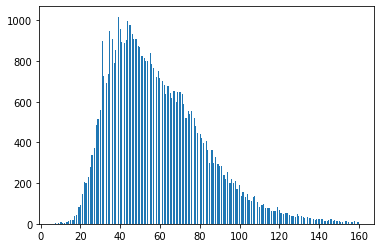

In [200]:
import matplotlib.pyplot as plt
max_r = np.array(max_r)
plt.hist(max_r[max_r<=256], bins=256)

(array([2.000e+00, 1.000e+00, 3.000e+00, 7.000e+00, 4.000e+00, 3.000e+00,
        7.000e+00, 1.200e+01, 1.700e+01, 1.800e+01, 3.600e+01, 4.500e+01,
        8.200e+01, 9.000e+01, 1.470e+02, 2.060e+02, 1.990e+02, 2.320e+02,
        2.790e+02, 3.390e+02, 3.720e+02, 4.860e+02, 5.130e+02, 0.000e+00,
        5.590e+02, 8.980e+02, 7.290e+02, 6.900e+02, 7.340e+02, 9.470e+02,
        9.100e+02, 7.920e+02, 8.550e+02, 1.018e+03, 9.560e+02, 8.950e+02,
        8.900e+02, 9.030e+02, 9.980e+02, 9.760e+02, 9.340e+02, 9.080e+02,
        9.090e+02, 8.720e+02, 8.690e+02, 8.250e+02, 0.000e+00, 8.170e+02,
        8.020e+02, 8.000e+02, 8.420e+02, 7.850e+02, 7.660e+02, 7.230e+02,
        7.500e+02, 7.160e+02, 7.020e+02, 6.840e+02, 6.400e+02, 6.760e+02,
        6.450e+02, 6.190e+02, 6.530e+02, 6.010e+02, 6.500e+02, 6.470e+02,
        6.370e+02, 5.870e+02, 5.220e+02, 0.000e+00, 5.550e+02, 5.410e+02,
        5.550e+02, 5.190e+02, 4.810e+02, 4.460e+02, 4.410e+02, 4.220e+02,
        3.970e+02, 4.080e+02, 3.640e+0

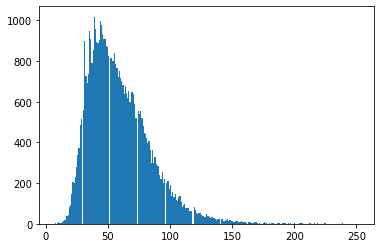

In [195]:
import matplotlib.pyplot as plt

plt.hist(max_r[max_r<=256], bins=256)

In [182]:
tok_dataset

Dataset({
    features: ['input_ids', 'base_len', 'rhyme_ids'],
    num_rows: 49828
})

In [180]:
tokenizer.decode(max_r['input_ids'])

"_START_SECTION_ Herrar _START_PARAGRAPH_ 100 meter 1 Joseph Gikonyo, Kenya, 10,28 2 Abdullahi Tetengi, Nigeria, 10,36 3 Charles-Louis Seck, Senegal, 10,38 200 meter 1 Joseph Gikonyo, Kenya, 20,89 2 Abdullahi Tetengi, Nigeria, 21,01 3 Sunday Bada, Nigeria, 21,05 400 meter 1Samson Kitur, Kenya, 45,15 2 David Kitur, Kenya, 46,13 3 Sunday Bada, Nigeria, 46,19 800 meter 1 William Tanui, Kenya, 1.46,80 2 Robert Kibet, Kenya, 1.47,15 3 Desta Asgedom, Etiopien, 1.47,38 1 500 meter 1 Moses Kiptanui, Kenya, 3.39,51 2 Abdelaziz Sahere, Marocko, 3.39,53 3 David Kibet, Kenya, 3.41,49 5 000 meter 1 Ezequeil Bitok, Kenya, 13.33,30 2 Andrew Sambu, Tanzania, 13.33,90 3 Mohamed Issangar, Marocko, 13.34,37 10 000 meter 1 Khalid Skah, Marocko, 28.31,10 2 Andrew Sambu, Tanzania, 28.31,50 3 Addis Abebe, Etiopien, 28.34,40 Maraton 1 Tesfaye Tafa, Etiopien2:33.38 2 Belaye Wolashe, Etiopien, 2:37.17 3 Negash Dube, Etiopien, 2:49.42 3 000 meter hinder 1 Abdelaziz Sahere, Marocko, 8.33,58 2 William Mutwol, Keny

In [174]:
max_i

6699

In [172]:
max(len(x['input_ids']) for x in tok_dataset)

3962

In [28]:
lm_dataset = tok_dataset.map(group_texts, batched=True, num_proc=4)

#0:   0%|          | 0/6 [00:00<?, ?ba/s]

#1:   0%|          | 0/6 [00:00<?, ?ba/s]

#2:   0%|          | 0/6 [00:00<?, ?ba/s]

#3:   0%|          | 0/6 [00:00<?, ?ba/s]

In [33]:
lm_dataset[0]['input_ids']

[67,
 55,
 8898,
 16704,
 67,
 25929,
 16703,
 31230,
 67,
 4874,
 368,
 5077,
 2233,
 225,
 67,
 55,
 8898,
 16704,
 67,
 2335,
 39,
 41069,
 20485,
 67,
 3531,
 3257,
 225,
 67,
 55,
 8898,
 16704,
 67,
 13096,
 7045,
 43,
 7045,
 52,
 44,
 67,
 7800,
 2037,
 285,
 225,
 67,
 35669,
 67,
 4874,
 368,
 5077,
 1237,
 285,
 43310,
 28292,
 3487,
 9888,
 1611,
 225,
 67,
 55,
 54,
 67,
 285,
 4853,
 621,
 3896,
 1393,
 10971,
 6216,
 285,
 1678,
 18,
 225,
 67,
 44927,
 59,
 48,
 18306,
 41,
 67,
 47486,
 5139,
 2627,
 2546,
 225,
 67,
 35669,
 67,
 1931,
 285,
 37553,
 11885,
 2233,
 313,
 2546,
 17996,
 225,
 67,
 55,
 54,
 67,
 3502,
 285,
 22354,
 719,
 313,
 2553,
 7766,
 319,
 22354,
 744,
 18,
 67,
 55,
 8898,
 16704,
 67,
 25929,
 16703,
 31230,
 67,
 16094,
 1758,
 1533,
 427,
 17670,
 225,
 67,
 55,
 8898,
 16704,
 67,
 13096,
 7045,
 43,
 7045,
 52,
 44,
 67,
 500,
 2306,
 1758,
 1533,
 427,
 17670,
 359,
 2129,
 2582,
 225,
 67,
 35669,
 67,
 1146,
 75,
 91,
 862,
 293,
 625,

In [66]:
print(rhymeify(dataset['train'][0]['text']))

_START_ARTICLE_ Åke Fridell _START_SECTION_ Biografi _START_PARAGRAPH_ Åke Fridell växte upp _FIRSTRHYME_
 i Falun och arbetade först som kärntrupp _SECONDRHYME_
 springschas och därefter som expedit i en färgaffär. Han spelade också _FIRSTRHYME_
 en del amatörteater. I 20-årsåldern flyttade isblå _SECONDRHYME_
 han till Stockholm, där han började ta sånglektioner för _FIRSTRHYME_
 Nils Strandberg._NEWLINE_Fridell studerade drama för Axel alltför _SECONDRHYME_
 Witzansky. Han scendebuterade 1944, och fram till 1965 var _FIRSTRHYME_
 han engagerad vid Malmö stadsteater och tillämpbar _SECONDRHYME_
 Helsingborgs stadsteater. Där gav Ingmar Bergman honom den första _FIRSTRHYME_
 stora scenrollen i Jacobowsky och översten._NEWLINE_Han första _SECONDRHYME_
 filmdebuterade 1944 och kom att medverka i drygt 70 film- och _FIRSTRHYME_
 TV-produktioner. Fridell gestaltade ofta glada, bullriga spinnrock _SECONDRHYME_
 och livsnjutande gestalter. Särskilt bör här framhållas hans roller _FIRSTRHYME

In [1]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
checkpoint = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForMaskedLM.from_pretrained(checkpoint).cuda()
model.eval()

XLMRobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Laye

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
checkpoint = '/home/filip/Code/rimbo/checkpoints/rhymerev1_10h'#checkpoints/rhyme8tuning5h'#'birgermoell/swedish-gpt'
checkpoint = '/home/filip/Code/rimbo/rhymerev5'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForCausalLM.from_pretrained(checkpoint).cuda()
model.eval();
tokenizer.pad_token = '<|endoftext|>'

In [68]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
checkpoint = 'KBLab/bart-base-swedish-cased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForMaskedLM.from_pretrained(checkpoint).cuda()
model.eval()

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50185, 768, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50185, 768, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
      (layers): ModuleList(
        (0): BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): LayerNorm((768,), eps=1e-05,

In [95]:
import torch
sequences = ["Hunden springer över gatan [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] ."]
tokens = tokenizer(sequences, return_tensors="pt").to(torch.device(0))
output = model(**tokens)
tokenizer.decode(torch.argmax(output.logits, -1)[0,1:-1])

'Hunden springer över gatan...........'

In [21]:
import torch
sequences = ["What is updog? <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask> <mask>."]
tokens = tokenizer(sequences, return_tensors="pt").to(torch.device(0))
output = model(tokens.input_ids)
tokenizer.decode(torch.argmax(output.logits, -1)[0,1:-1])

'What is updog?  is,,   ..'

In [3]:
import torch
sequences = ['Mörkret lägger sig och dagen blir natt\noch över gatan springer en svart']
#["Apelsin är en stor och rund frukt\n"]#["Apelsinen har en behaglig lukt\n"]#
# tokenizer.pad_token = tokenizer.eos_token
tokens = tokenizer(sequences, return_tensors="pt").to(torch.device(0))
# tokens.attention_mask[0][9:] = 0
output = model(**tokens)
output.logits.shape
# tokenizer.decode(torch.argmax(output.logits, -1)[0]).split()[-1]
tokenizer.decode(torch.argmax(output.logits[0,-1,:]))

','

In [14]:
tokenizer.decode(torch.argmax(output.logits[0,-1,:]))

's'

In [16]:
tokenizer.decode([87])

's'

In [13]:
torch.argmax(output.logits, -1)[0]

tensor([339, 309, 299, 284, 309, 284,  18, 284, 309, 284,  18, 476, 341, 285,
        285, 309, 263,  18, 309,  87], device='cuda:0')

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 2.000e+00, 4.000e+00, 3.000e+00, 7.000e+00,
        1.400e+01, 1.800e+01, 2.100e+01, 4.100e+01, 7.400e+01, 9.000e+01,
        1.340e+02, 2.180e+02, 2.820e+02, 3.780e+02, 5.240e+02, 7.530e+02,
        9.910e+02, 1.223e+03, 1.417e+03, 1.764e+03, 2.085e+03, 2.310e+03,
        2.567e+03, 2.756e+03, 2.861e+03, 2.976e+03, 2.783e+03, 2.812e+03,
        2.689e+03, 2.479e+03, 2.363e+03, 2.067e+03, 1.842e+03, 1.626e+03,
        1.442e+03, 1.163e+03, 1.066e+03, 8.180e+02, 7.460e+02, 5.950e+02,
        4.950e+02, 4.250e+02, 3.090e+02, 2.700e+02, 2.020e+02, 1.490e+02,
        1.180e+02, 8.500e+01, 6.800e+01, 3.100e+01, 3.400e+01, 2.500e+01,
        1.700e+01, 9.000e+00, 6.000e+0

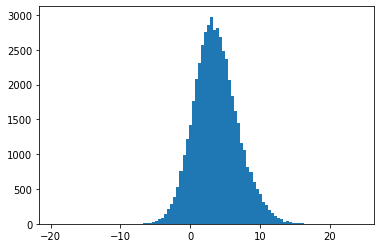

In [46]:
import matplotlib.pyplot as plt
ls = sl.cpu().detach().numpy()
plt.hist(ls, bins=100)

In [ ]:
torch.softmax(output.logits[0,-1])

In [124]:
sl, si = torch.sort(torch.softmax(output.logits[0,-1], -1))

In [117]:
sl, si = torch.sort(output.logits[0,-1])

In [123]:
[(tokenizer.decode([i]),v.item()) for i,v in zip(si[-10:],sl[-10:])]

[(' qu', 0.009485582821071148),
 (' orm', 0.01103246957063675),
 (' man', 0.013333053328096867),
 (' sot', 0.01404584851115942),
 (' katt', 0.015339769423007965),
 (' h', 0.0165498498827219),
 (' skytt', 0.018267912790179253),
 ('klädd', 0.020215684548020363),
 (' korp', 0.03388983756303787),
 (' hund', 0.07614393532276154)]

In [30]:
output.logits[0,-1,12594]

tensor(16.5054, device='cuda:0', grad_fn=<SelectBackward0>)

In [31]:
output.logits[0,-1,87]

tensor(24.2144, device='cuda:0', grad_fn=<SelectBackward0>)

In [13]:
rhymedb['katt']

['färgglatt',
 'flatskratt',
 'straffskatt',
 'cowboyhatt',
 'ägnat',
 'sjösatt',
 'färgsatt',
 'midnatt',
 'spratt',
 'inkluderat',
 'tafatt',
 'vårdskatt',
 'stråhatt',
 'huskatt',
 'paneldebatt',
 'tillsatt',
 'uppsatt',
 'besatt',
 'vaknatt',
 'påverkat',
 'avkastningsskatt',
 'ratt',
 'bolagsskatt',
 'godnatt',
 'kvarskatt',
 'kilowatt',
 'bosatt',
 'bilskatt',
 'samhällsdebatt',
 'fortsatt',
 'debatt',
 'ifrågasatt',
 'pantsatt',
 'statt',
 'iscensatt',
 'kattegatt',
 'interpellationsdebatt',
 'kravatt',
 'natt',
 'katt',
 'smaksatt',
 'konstskatt',
 'utsatt',
 'försatt',
 'kulturdebatt',
 'stensatt',
 'filthatt',
 'khat',
 'minskat',
 'förutsatt',
 'kommunalskatt',
 'skoldebatt',
 'sammansatt',
 'hävdat',
 'restskatt',
 'vinstskatt',
 'förmånsskatt',
 'igångsatt',
 'vinstdelningsskatt',
 'miljöskatt',
 'sysselsatt',
 'nyöversatt',
 'preliminärskatt',
 'lussekatt',
 'insatt',
 'miljödebatt',
 'studerat',
 'arvsskatt',
 'sommarkatt',
 'blomsterrabatt',
 'tatt',
 'fnatt',
 'slatt',

In [76]:
tokenizer([' katt'])

{'input_ids': [[12594]], 'attention_mask': [[1]]}

In [18]:
text = 'Mörkret lägger sig och dagen blir natt \noch över gatan springer en svart'

In [5]:
reverse(text)

'svart en springer gatan över och natt blir dagen och sig lägger Mörkret'

In [3]:
def reverse(text):
    return ' '.join(text.split()[::-1])

In [ ]:
Apelsin är en stor rund frukt
Den har en väldigt god lukt

In [ ]:
<s>Den har en väldigt god lukt</s>Apelsin är en stor rund frukt<unk>

In [ ]:
#reverse(<s>"secondline"</s>"firstline"<unk>)

In [221]:
import torch
sequences = [reverse('borgen</s>I fröjd och jubel byttes sorgen<unk>')]#Mörkret lägger sig och dagen blir katt<unk>
#["Apelsin är en stor och rund frukt\n"]#["Apelsinen har en behaglig lukt\n"]# natt</s>och över gatan springer en svart katt
# tokenizer.pad_token = tokenizer.eos_token
tokens = tokenizer(sequences, return_tensors="pt").to(torch.device(0))
# tokens.attention_mask[0][9:] = 0
# output = model(**tokens)
# output.logits.shape
# tokenizer.decode(torch.argmax(output.logits, -1)[0]).split()[-1]
# tokenizer.decode(torch.argmax(output.logits[0,-1,:]))

In [5]:
tokenizer.decode(list(range(100)))

'<s><pad></s><unk><mask>!"#$%&\'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\\]^_`abcdefghijklmnopqrstuvwxyz{|}~�'

In [42]:
rhymedb['katt']

['färgglatt',
 'flatskratt',
 'straffskatt',
 'cowboyhatt',
 'ägnat',
 'sjösatt',
 'färgsatt',
 'midnatt',
 'spratt',
 'inkluderat',
 'tafatt',
 'vårdskatt',
 'stråhatt',
 'huskatt',
 'paneldebatt',
 'tillsatt',
 'uppsatt',
 'besatt',
 'vaknatt',
 'påverkat',
 'avkastningsskatt',
 'ratt',
 'bolagsskatt',
 'godnatt',
 'kvarskatt',
 'kilowatt',
 'bosatt',
 'bilskatt',
 'samhällsdebatt',
 'fortsatt',
 'debatt',
 'ifrågasatt',
 'pantsatt',
 'statt',
 'iscensatt',
 'kattegatt',
 'interpellationsdebatt',
 'kravatt',
 'natt',
 'katt',
 'smaksatt',
 'konstskatt',
 'utsatt',
 'försatt',
 'kulturdebatt',
 'stensatt',
 'filthatt',
 'khat',
 'minskat',
 'förutsatt',
 'kommunalskatt',
 'skoldebatt',
 'sammansatt',
 'hävdat',
 'restskatt',
 'vinstskatt',
 'förmånsskatt',
 'igångsatt',
 'vinstdelningsskatt',
 'miljöskatt',
 'sysselsatt',
 'nyöversatt',
 'preliminärskatt',
 'lussekatt',
 'insatt',
 'miljödebatt',
 'studerat',
 'arvsskatt',
 'sommarkatt',
 'blomsterrabatt',
 'tatt',
 'fnatt',
 'slatt',

In [37]:
model.generate?

Signature:
model.generate(
    inputs: Optional[torch.Tensor] = None,
    max_length: Optional[int] = None,
    min_length: Optional[int] = None,
    do_sample: Optional[bool] = None,
    early_stopping: Optional[bool] = None,
    num_beams: Optional[int] = None,
    temperature: Optional[float] = None,
    top_k: Optional[int] = None,
    top_p: Optional[float] = None,
    typical_p: Optional[float] = None,
    repetition_penalty: Optional[float] = None,
    bad_words_ids: Optional[Iterable[int]] = None,
    bos_token_id: Optional[int] = None,
    pad_token_id: Optional[int] = None,
    eos_token_id: Optional[int] = None,
    length_penalty: Optional[float] = None,
    no_repeat_ngram_size: Optional[int] = None,
    encoder_no_repeat_ngram_size: Optional[int] = None,
    num_return_sequences: Optional[int] = None,
    max_time: Optional[float] = None,
    max_new_tokens: Optional[int] = None,
    decoder_start_token_id: Optional[int] = None,
    use_cache: Optional[bool] = None,
    n

In [235]:
N = 10
output = model.generate(tokens.input_ids, top_k=30, do_sample=True, max_length=20, repitition_penalty=1.2, num_return_sequences=N)#, ) top_p=0.5,
tokenizer.batch_decode(tokenizer(['     '.join(reverse(tokenizer.batch_decode(output)[i]).split('</s>')[::-1]) for i in range(N)]).input_ids, skip_special_tokens=True)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


['I fröjd och jubel byttes sorgen     Ur han steg till borgen',
 'I fröjd och jubel byttes sorgen     beta bergen i natten och straxt i borgen',
 'I fröjd och jubel byttes sorgen     gyllne frillors straxt i borgen',
 'I fröjd och jubel byttes sorgen     bygga mörkret sänkte borgen',
 'I fröjd och jubel byttes sorgen     En dolk fram från borgen',
 'I fröjd och jubel byttes sorgen     då närde sig på borgen',
 'I fröjd och jubel byttes sorgen     Valkyriqn fram ur borgen',
 'I fröjd och jubel byttes sorgen     Och steg till borgen',
 'I fröjd och jubel byttes sorgen     Ren gyllne gångar under borgen',
 'I fröjd och jubel byttes sorgen     mot skuggor av borgen']

In [64]:
output = model.generate(tokens.input_ids, typical_p=0.8, do_sample=True)#, typical_p=0.2)
reverse(tokenizer.batch_decode(output)[0])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'silfver och med praktfull skölde</s>Hvad sjelf Gudinna ej evigt katt<unk>'

In [7]:
output = model.generate(tokens.input_ids, num_beams=100, top_k=10, do_sample=True)
reverse(tokenizer.batch_decode(output)[0])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'man gör att man gör att man gör att man gör att man gör att man förråder <unk>'

In [38]:
output = model.generate(tokens.input_ids, typical_p=0.2, max_length=40, do_sample=True)#, typical_p=0.2)
reverse(tokenizer.batch_decode(output)[0])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'<s>Hvem<|endoftext|><|endoftext|></s>Som<|endoftext|><s>Hur<|endoftext|> har ej än mer åt henne Hon än hafva vigt sig säger att hon en honnören till sig ej sig <unk>erehanda'

In [77]:
output = model.generate(tokens.input_ids, num_beams=1, top_k=10, do_sample=True)
reverse(tokenizer.batch_decode(output)[0])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'för den choschen </s>O är säll vid din kind för mig fram i ett frukt<unk>'

In [112]:
model.generate?

Signature:
model.generate(
    inputs: Optional[torch.Tensor] = None,
    max_length: Optional[int] = None,
    min_length: Optional[int] = None,
    do_sample: Optional[bool] = None,
    early_stopping: Optional[bool] = None,
    num_beams: Optional[int] = None,
    temperature: Optional[float] = None,
    top_k: Optional[int] = None,
    top_p: Optional[float] = None,
    typical_p: Optional[float] = None,
    repetition_penalty: Optional[float] = None,
    bad_words_ids: Optional[Iterable[int]] = None,
    bos_token_id: Optional[int] = None,
    pad_token_id: Optional[int] = None,
    eos_token_id: Optional[int] = None,
    length_penalty: Optional[float] = None,
    no_repeat_ngram_size: Optional[int] = None,
    encoder_no_repeat_ngram_size: Optional[int] = None,
    num_return_sequences: Optional[int] = None,
    max_time: Optional[float] = None,
    max_new_tokens: Optional[int] = None,
    decoder_start_token_id: Optional[int] = None,
    use_cache: Optional[bool] = None,
    n

In [12]:
class TopPK():
    def __init__(self, k=0, p=0.0, temp=1.0): self.k, self.p, self.temp = k, p, temp
    
    def __call__(self, outputs):
        logits = output.logits[0] / self.temp
        
        if self.k > 0:
            indices_to_remove = logits < torch.topk(logits, self.k, dim=-1)[0][..., -1, None]
            logits[indices_to_remove] = -float('Inf')
        
        if self.p > 0:
            sorted_logits, sorted_indices = torch.sort(logits, descending=True)
            cumulative_probs = torch.cumsum(torch.softmax(sorted_logits, dim=-1), dim=-1)
            # Remove tokens with cumulative probability above the threshold
            sorted_indices_to_remove = cumulative_probs > self.p
            # Shift the indices to the right to keep also the first token above the threshold
            sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
            sorted_indices_to_remove[..., 0] = 0
            indices_to_remove = sorted_indices_to_remove.scatter(dim=1, index=sorted_indices, src=sorted_indices_to_remove)
            logits[indices_to_remove] = -float('Inf')
            
        probs = torch.softmax(logits, -1)
        return torch.multinomial(probs, 1)


def diffusion_fill(model, tokenizer, sequence, sample_function=TopPK(1)):
    mask_id = tokenizer.mask_token_id
    model = model.cuda()
    tokens = tokenizer([sequence], return_tensors='pt').to(torch.device(0))
    while mask_id in tokens.input_ids:
        output = model(**tokens)
        mask_idxs = torch.nonzero(tokens.input_ids == mask_id)[:,1]
        best_idx = mask_idxs[output.logits[0,mask_idxs,:].sum(-1).argmax()] # highest sum or single prob?
        out_tokens = sample_function(output)
        tokens.input_ids[0][best_idx] = out_tokens[best_idx]
        
    return tokenizer.decode(tokens.input_ids[0,1:-1])

def mutate_fill(model, tokenizer, sequence, mask_idxs=None, iterations=100, burnin_pct=0.5, sample_function=TopPK(30, 0.6)):
    from tqdm import tqdm
    burnin_iters = int(burnin_pct * iterations)
    model = model.cuda()
    mask_id = tokenizer.mask_token_id
    tokens = tokenizer([sequence], return_tensors='pt').to(torch.device(0))
    if mask_idxs is None:
        mask_idxs = torch.nonzero(tokens.input_ids == mask_id)[:,1]
    for iteration in tqdm(range(iterations)):
        for idx in mask_idxs:
            tokens.input_ids[0][idx] = mask_id
            output = model(**tokens)
            out_tokens = sample_function(output) if iteration >= burnin_iters else TopPK()(output)
            tokens.input_ids[0][idx] = out_tokens[idx]
        mask_idxs = mask_idxs[torch.randperm(len(mask_idxs))]
    return tokenizer.decode(tokens.input_ids[0,1:-1])

In [22]:
diffusion_fill(model, tokenizer, sequences[0], TopPK(20,0.9,1.5))

'What is updog? You what. on and and ....'

In [23]:
mutate_fill(model, tokenizer, sequences[0], iterations=200, burnin_pct=0.8, sample_function=TopPK(40, 0.8, 1))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:23<00:00,  8.54it/s]


'What is updog? What is it thes of the dog..'